# Face recognition inference pipeline
[source](https://github.com/timesler/facenet-pytorch/blob/master/examples/infer.ipynb)

In [21]:
import os
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from facenet_pytorch import InceptionResnetV1
from fpt.path import FACE, DTFR
from fpt.data import join_face_df

In [22]:
def collate_fn(x):
    return x[0]

In [23]:
DATA_CATEGORY = "aihub_sample"
# Define variable
workers = 0 if os.name == "nt" else 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# Define dataset, dataloader, model
dataset = datasets.ImageFolder(str(FACE / f"training_{DATA_CATEGORY}"))
setattr(dataset, "idx_to_class", {i: c for c, i in dataset.class_to_idx.items()})
loader = DataLoader(
    dataset,
    num_workers=workers,
    collate_fn=collate_fn,
)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

In [25]:
# Preprocess  (6.0s)
idx_to_class = getattr(dataset, "idx_to_class")
aligned = []
names = []
for x, y in tqdm(loader):
    break
    arr_img = np.array(x.resize([160, 160]), dtype=np.float32)
    img_cropped = torch.from_numpy(arr_img)
    x_aligned = img_cropped.permute([2, 0, 1])
    aligned.append(x_aligned)
    names.append(idx_to_class[y])

  0%|          | 0/292 [00:00<?, ?it/s]


In [26]:
# Inference: Embedding  (10.7s)
# aligned = torch.stack(aligned).to(device)
# embeddings = resnet(aligned).detach().cpu()

In [27]:
# Save embedding
fp = f"data/embedding/{DATA_CATEGORY}.txt"
# np.savetxt(fp, embeddings.numpy())

In [28]:
uuids = [Path(path).stem for path, target in dataset.imgs]

In [29]:
# Load embedding
embeddings = np.loadtxt(fp)
embedding_dict = {uuid: embedding for uuid, embedding in zip(uuids, embeddings)}

In [30]:
face = join_face_df(DTFR)

In [31]:
groups = (
    face.sort_values(by="option")
    .reset_index()
    .groupby(["family_id", "personal_id", "category"])
)

In [32]:
tags1 = "F0003", "D", "Family"
label1 = "-".join(tags1)

age_group1 = groups.uuid.apply(list).to_frame()
age_uuids1 = age_group1.loc[tags1, "uuid"]
age_array1 = np.stack([embedding_dict[uuid] for uuid in age_uuids1])  # type:ignore

groups_name1 = groups.option.apply(list).to_frame()
age_options1 = groups_name1.loc[tags1, "option"]
age_names1 = [f"{str(opt)}" for _, opt in zip(age_uuids1, age_options1)]  # type:ignore

groups_path1 = groups.path.apply(list).to_frame()
age_paths1 = groups_path1.loc[tags1, "path"]

In [33]:
tags2 = "F0001", "D", "Family"
label2 = "-".join(tags2)

age_group2 = groups.uuid.apply(list).to_frame()
age_uuids2 = age_group2.loc[tags2, "uuid"]
age_array2 = np.stack([embedding_dict[uuid] for uuid in age_uuids2])  # type:ignore

groups_name2 = groups.option.apply(list).to_frame()
age_options2 = groups_name2.loc[tags2, "option"]
age_names2 = [f"{str(opt)}" for _, opt in zip(age_uuids2, age_options2)]  # type:ignore

groups_path2 = groups.path.apply(list).to_frame()
age_paths2 = groups_path2.loc[tags2, "path"]

# Visualize

In [34]:
from PIL import Image
import pandas as pd
from matplotlib import ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Matched

In [35]:
# Euclidean distance
dists = [[np.linalg.norm(e1 - e2) for e2 in age_array1] for e1 in age_array1]
out = pd.DataFrame(dists, columns=age_names1, index=age_names1)

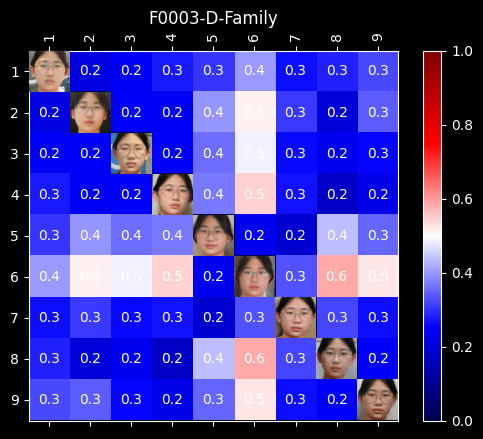

In [36]:
# Heatmap
fig, ax = plt.subplots()
im = ax.matshow(out, vmin=0, vmax=1, cmap="seismic")
fig.colorbar(im)
size = 40

i = range(len(age_names1))
ax.set(xticks=i, xticklabels=age_names1, yticks=i, yticklabels=age_names1)
ax.tick_params(axis="x", rotation=90)

l, m, r, n = ax.images[0].get_window_extent().get_points().flatten().tolist()
target = (r - 107.2 - ax.spines.right.get_linewidth()) / len(age_names1)
source = size * fig.dpi / 72.0

for (i, j), z in np.ndenumerate(out):
    if i == j:
        im = Image.open(age_paths1[i]).resize((size, size))  # type:ignore
        oi = OffsetImage(im, zoom=target / source)
        box = AnnotationBbox(oi, (i, j), frameon=False, pad=0)
        ax.add_artist(box)
        continue
    if len(age_names1) > 10:
        continue
    ax.text(j, i, "{:0.1f}".format(z), ha="center", va="center")
ax.set(title=f"{label1}")
ax.images[0].get_window_extent().get_points().flatten().tolist()
plt.show()

## Mismatched

In [37]:
# Euclidean distance
dists = [[np.linalg.norm(e1 - e2) for e2 in age_array2] for e1 in age_array1]
out2 = pd.DataFrame(dists, columns=age_names2, index=age_names1)
# Modify out2 for face image space
nx, ny = out2.shape
out2 = np.c_[out2, np.zeros(nx)]
out2 = np.r_[out2, np.zeros([1, ny + 1])]

In [38]:
xticker = ticker.FixedLocator(range(len(age_names2)))
yticker = ticker.FixedLocator(range(len(age_names1)))

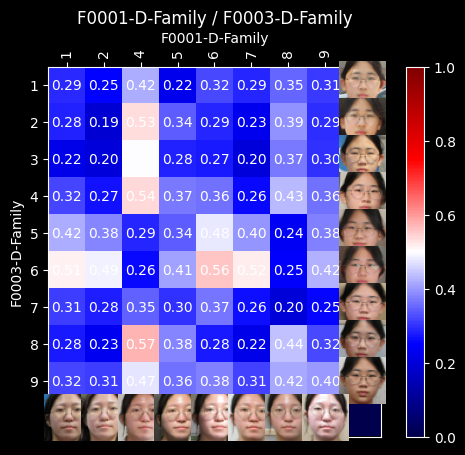

In [39]:
fig2, ax2 = plt.subplots()
im = ax2.matshow(out2, vmin=0, vmax=1, cmap="seismic")
cbar = fig2.colorbar(im)
size = 40

i1 = range(len(age_names1) + 1)
i2 = range(len(age_names2) + 1)
ax2.set(
    xticks=i2, xticklabels=age_names2 + [""], yticks=i1, yticklabels=age_names1 + [""]
)
ax2.tick_params(axis="x", rotation=90, bottom=False)

l, m, r, n = ax2.images[0].get_window_extent().get_points().flatten().tolist()
target = (r - 107.2 - ax2.spines.right.get_linewidth()) / len(age_names2)
source = size * fig2.dpi / 72.0

for (i, j), z in np.ndenumerate(out2):
    if i != nx and j == ny:
        im = Image.open(age_paths1[i]).resize((size, size))  # type:ignore
        oi = OffsetImage(im, zoom=target / source)
        box = AnnotationBbox(oi, (j, i), frameon=False, pad=0)
        ax2.add_artist(box)
        continue
    if i == nx and j != ny:
        im = Image.open(age_paths2[j]).resize((size, size))  # type:ignore
        oi = OffsetImage(im, zoom=target / source)
        box = AnnotationBbox(oi, (j, i), frameon=False, pad=0)
        ax2.add_artist(box)
    if len(age_names1) > 10 or len(age_names2) > 10:
        continue
    if i != nx and j != ny:
        ax2.text(j, i, "{:0.2f}".format(z), ha="center", va="center")

ax2.set(title=f"{label2} / {label1}")
ax2.set_xlabel(f"{label2}")
ax2.set_ylabel(f"{label1}")
ax2.xaxis.set_label_position("top")
ax2.xaxis.set_major_locator(xticker)
ax2.yaxis.set_major_locator(yticker)
plt.show()